## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eda_helper_functions
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

## 2. Read the Training Data

In [2]:
file_path = r"D:\Portfolio\Flight-Price-Prediction-using-Amazon-SageMaker\data\train.csv"
train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-21,Delhi,Cochin,17:15:00,19:15:00,1560,2.0,No Info,8245
1,Vistara,2019-05-15,Kolkata,Banglore,07:10:00,10:45:00,1655,1.0,No Info,8452
2,Jet Airways,2019-06-09,Banglore,Delhi,18:55:00,22:00:00,185,0.0,No Info,8016
3,Air India,2019-06-09,Kolkata,Banglore,09:50:00,23:15:00,805,3.0,No Info,14960
4,Spicejet,2019-05-09,Banglore,Delhi,05:55:00,08:35:00,160,0.0,No check-in baggage included,3573
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-09,Delhi,Cochin,19:15:00,04:25:00,550,1.0,In-flight meal not included,14053
636,Jet Airways,2019-03-27,Mumbai,Hyderabad,02:55:00,04:25:00,90,0.0,In-flight meal not included,1840
637,Multiple Carriers,2019-06-12,Delhi,Cochin,09:45:00,16:10:00,385,1.0,No Info,9646
638,Indigo,2019-04-15,Banglore,Delhi,22:10:00,01:00:00,170,0.0,No Info,3943


### 2.1 Fixing Data Types

In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
    col: pd.to_datetime(train.loc[:, col], dayfirst=True)
    for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [5]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-21,Delhi,Cochin,2024-05-25 17:15:00,2024-05-25 19:15:00,1560,2.0,No Info,8245
1,Vistara,2019-05-15,Kolkata,Banglore,2024-05-25 07:10:00,2024-05-25 10:45:00,1655,1.0,No Info,8452
2,Jet Airways,2019-06-09,Banglore,Delhi,2024-05-25 18:55:00,2024-05-25 22:00:00,185,0.0,No Info,8016
3,Air India,2019-06-09,Kolkata,Banglore,2024-05-25 09:50:00,2024-05-25 23:15:00,805,3.0,No Info,14960
4,Spicejet,2019-05-09,Banglore,Delhi,2024-05-25 05:55:00,2024-05-25 08:35:00,160,0.0,No check-in baggage included,3573
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-09,Delhi,Cochin,2024-05-25 19:15:00,2024-05-25 04:25:00,550,1.0,In-flight meal not included,14053
636,Jet Airways,2019-03-27,Mumbai,Hyderabad,2024-05-25 02:55:00,2024-05-25 04:25:00,90,0.0,In-flight meal not included,1840
637,Multiple Carriers,2019-06-12,Delhi,Cochin,2024-05-25 09:45:00,2024-05-25 16:10:00,385,1.0,No Info,9646
638,Indigo,2019-04-15,Banglore,Delhi,2024-05-25 22:10:00,2024-05-25 01:00:00,170,0.0,No Info,3943


## 3. High-level Summary of Data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [7]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,636.398438,0.787500,8865.918750
std,513.974545,0.670295,4252.394209
min,80.000000,0.000000,1840.000000
25%,170.000000,0.000000,5054.000000
50%,480.000000,1.000000,8024.500000
75%,976.250000,1.000000,12395.000000
max,2280.000000,3.000000,27992.000000


In [8]:
(
    train
    .assign(total_stops=train["total_stops"].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,3
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,224,269,269,333.0,517


## 4. High-level analysis of Missing Values

In [9]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


**Observations**:
    
- There are no missing values in the dataset.

## 5. High-level analysis of Outliers

In [10]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [11]:
(
    train
    .assign(outlier=forest.fit_predict(
        train
        .drop(columns="price")
        .select_dtypes(include="number")
    ))
    .query("outlier == -1")
    # .duration
    # .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-03-21,Delhi,Cochin,2024-05-25 17:15:00,2024-05-25 19:15:00,1560,2.0,No Info,8245,-1
1,Vistara,2019-05-15,Kolkata,Banglore,2024-05-25 07:10:00,2024-05-25 10:45:00,1655,1.0,No Info,8452,-1
2,Jet Airways,2019-06-09,Banglore,Delhi,2024-05-25 18:55:00,2024-05-25 22:00:00,185,0.0,No Info,8016,-1
3,Air India,2019-06-09,Kolkata,Banglore,2024-05-25 09:50:00,2024-05-25 23:15:00,805,3.0,No Info,14960,-1
6,Spicejet,2019-06-03,Mumbai,Hyderabad,2024-05-25 22:45:00,2024-05-25 00:15:00,90,0.0,No Info,2017,-1
...,...,...,...,...,...,...,...,...,...,...,...
613,Indigo,2019-03-27,Chennai,Kolkata,2024-05-25 13:20:00,2024-05-25 15:35:00,135,0.0,No Info,3384,-1
620,Vistara,2019-06-27,Chennai,Kolkata,2024-05-25 07:05:00,2024-05-25 09:20:00,135,0.0,No Info,3687,-1
624,Jet Airways,2019-03-09,Delhi,Cochin,2024-05-25 00:20:00,2024-05-25 04:25:00,1685,1.0,No Info,15029,-1
631,Jet Airways,2019-05-12,Kolkata,Banglore,2024-05-25 17:00:00,2024-05-25 23:35:00,395,1.0,No Info,14151,-1


## 6. Pair Plots

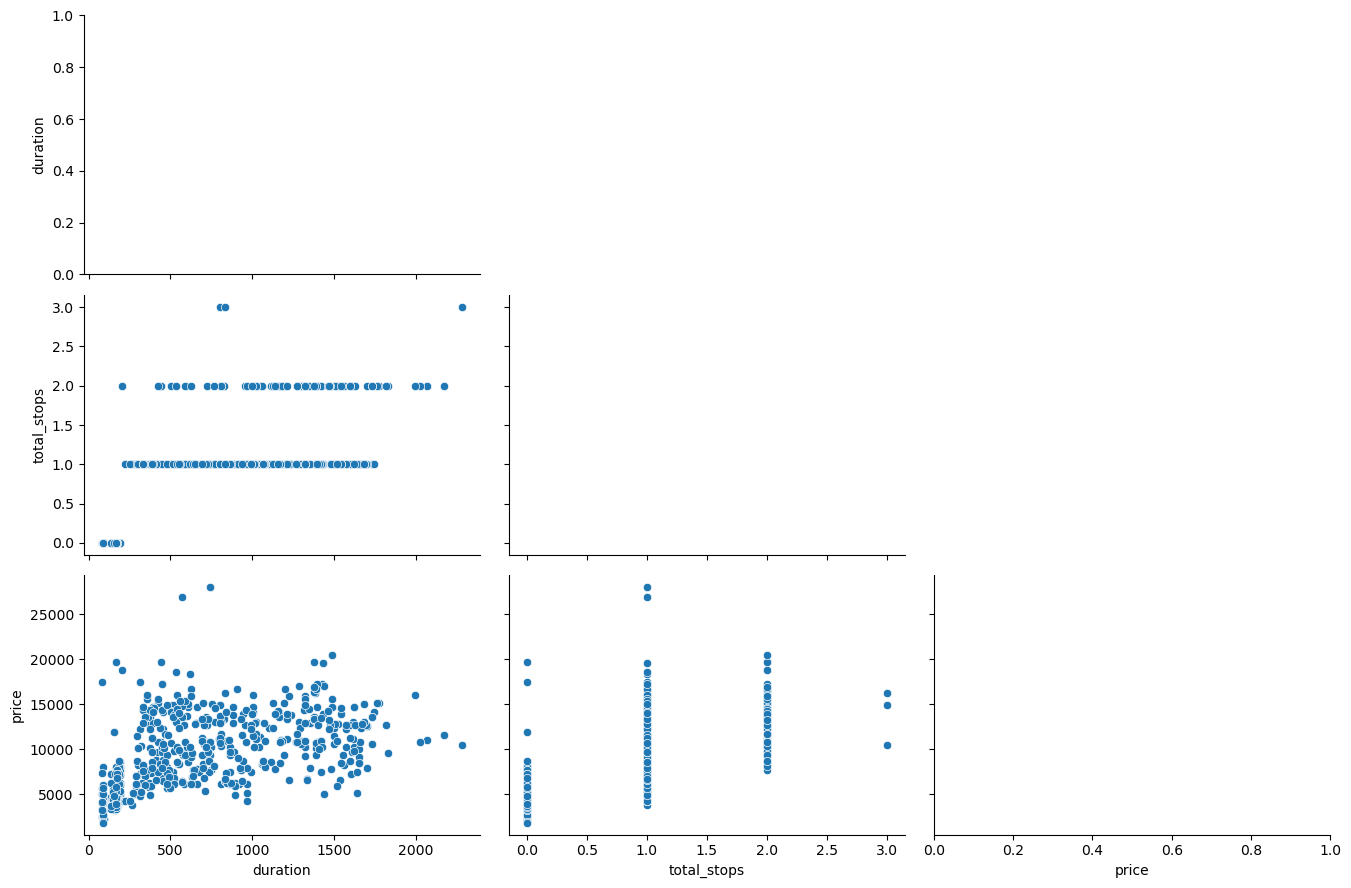

In [12]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

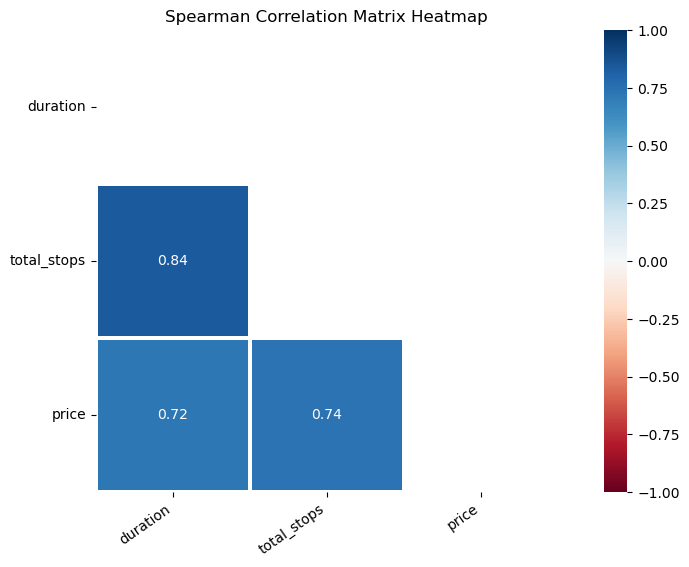

In [13]:
eda_helper_functions.correlation_heatmap(train)

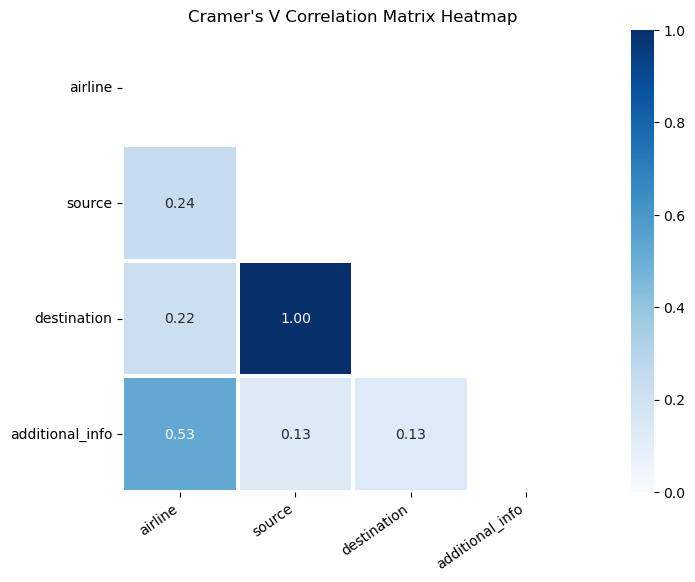

In [14]:
eda_helper_functions.cramersV_heatmap(train)

## 8. Detailed Analysis

In [15]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 `airline`

In [16]:
train.airline

0              Air India
1                Vistara
2            Jet Airways
3              Air India
4               Spicejet
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638               Indigo
639               Indigo
Name: airline, Length: 640, dtype: object

In [17]:
eda_helper_functions.cat_summary(train, "airline")

0              Air India
1                Vistara
2            Jet Airways
3              Air India
4               Spicejet
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638               Indigo
639               Indigo
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,224


,count,percentage
category,,
Jet Airways,224,0.350000
Indigo,159,0.248438
Air India,96,0.150000
Multiple Carriers,51,0.079687
Spicejet,48,0.075000
Vistara,35,0.054688
Air Asia,17,0.026562
Goair,10,0.015625


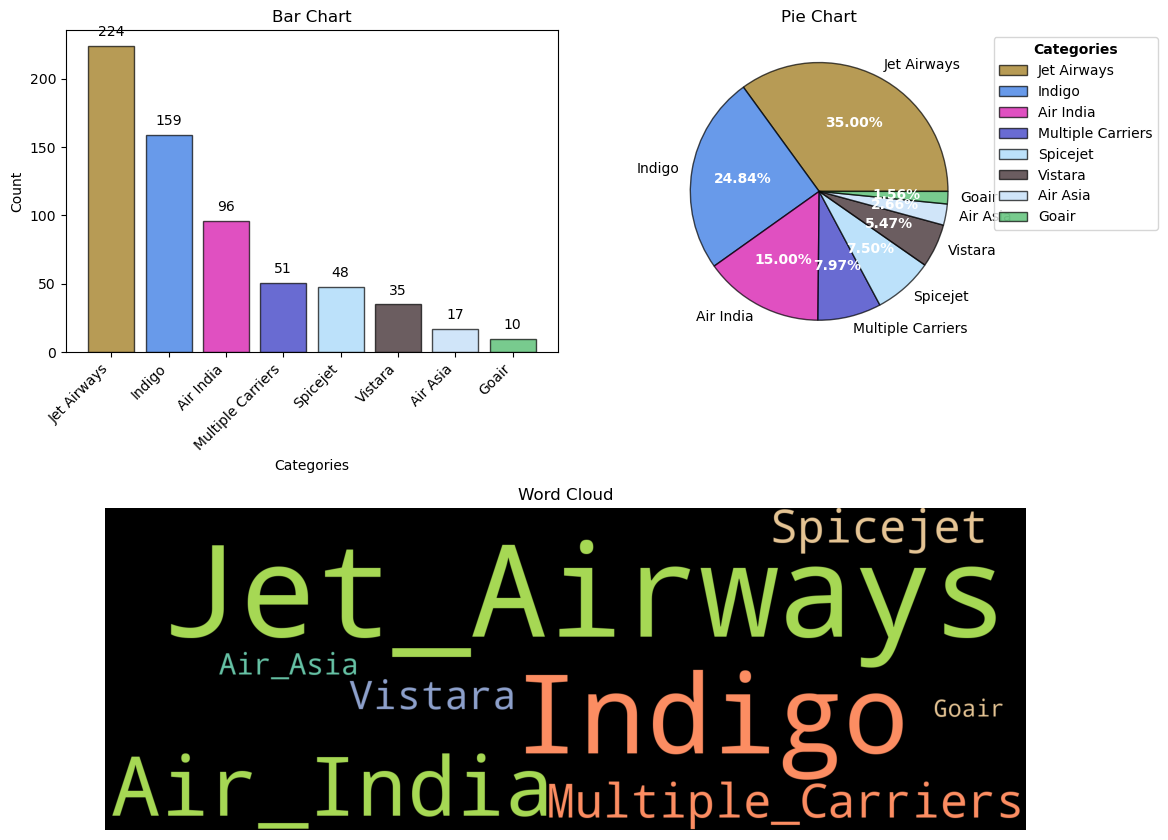

In [18]:
eda_helper_functions.cat_univar_plots(train, "airline")

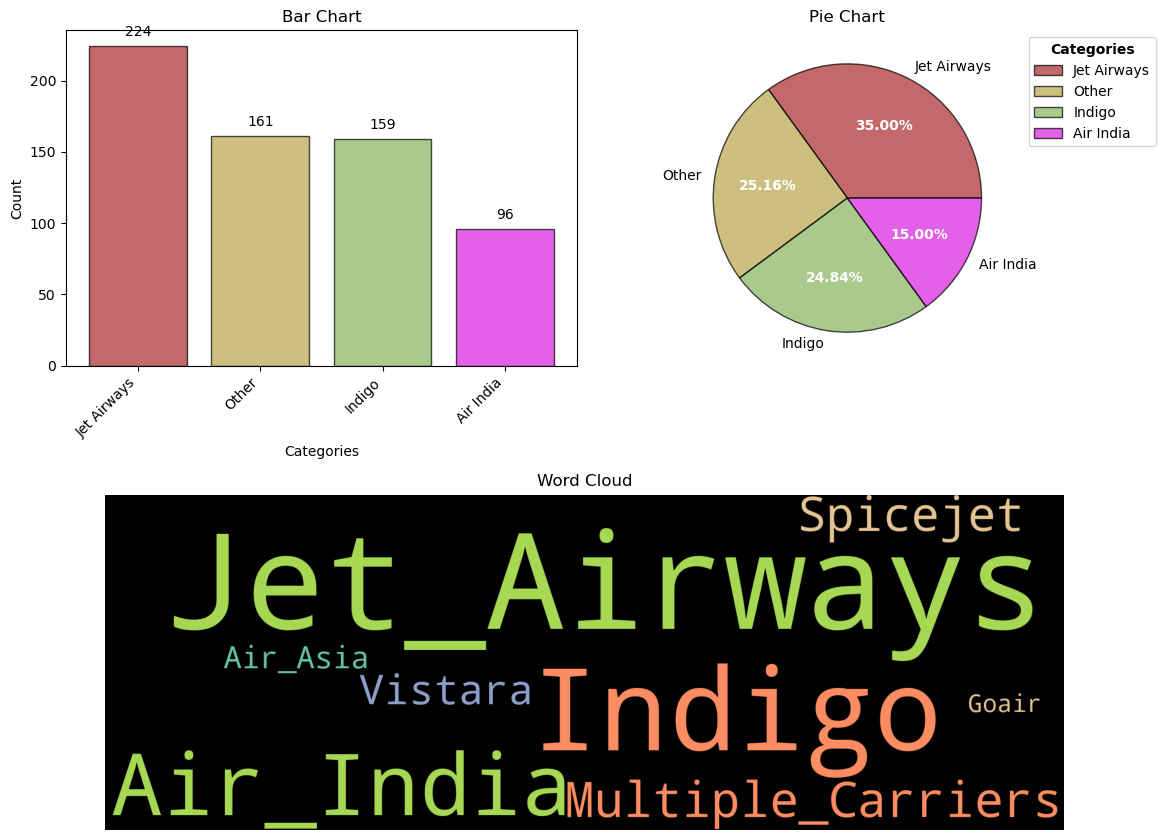

In [19]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=True, k=3)

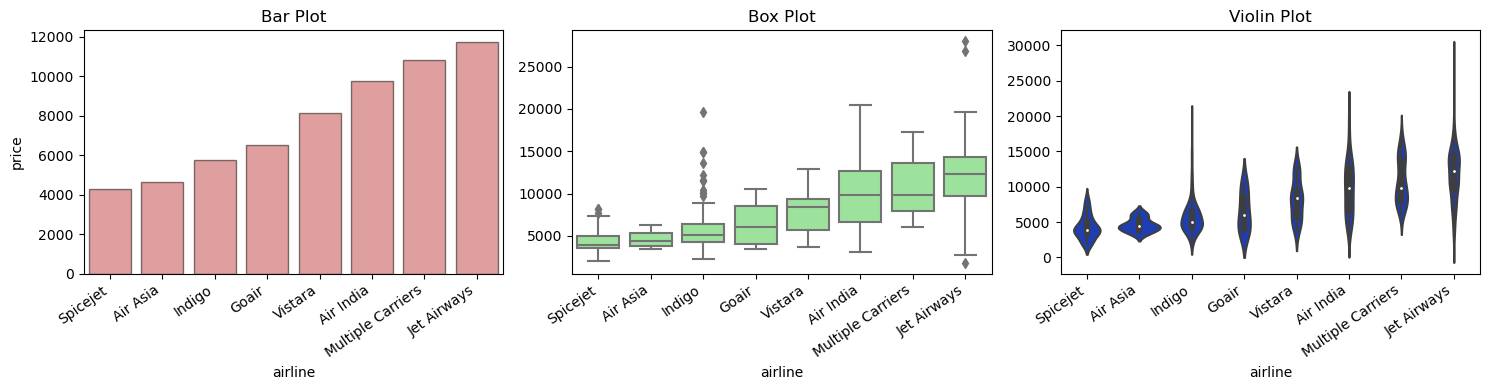

In [20]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var="price",
    cat_var="airline"
)

In [21]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 70.17924812240211
- p-value              : 8.233494165402703e-75
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 310.4816499132359
- p-value              : 3.489071606648905e-63
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


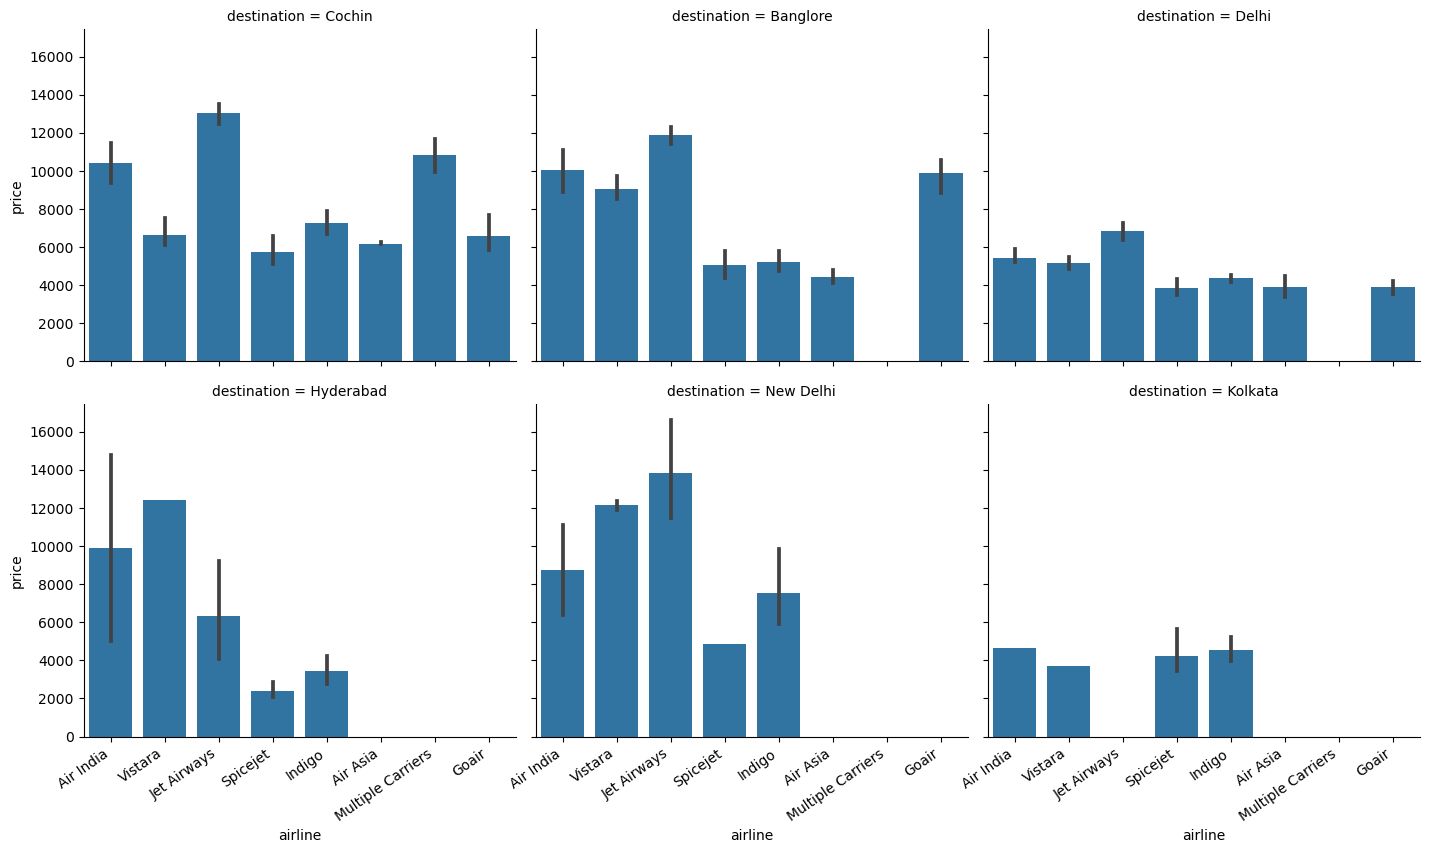

In [22]:
airline_grid = sns.FacetGrid(
    data=train,
    col="destination",
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

### 8.2 `date_of_journey`

In [23]:
train.date_of_journey

0     2019-03-21
1     2019-05-15
2     2019-06-09
3     2019-06-09
4     2019-05-09
         ...    
635   2019-03-09
636   2019-03-27
637   2019-06-12
638   2019-04-15
639   2019-05-09
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

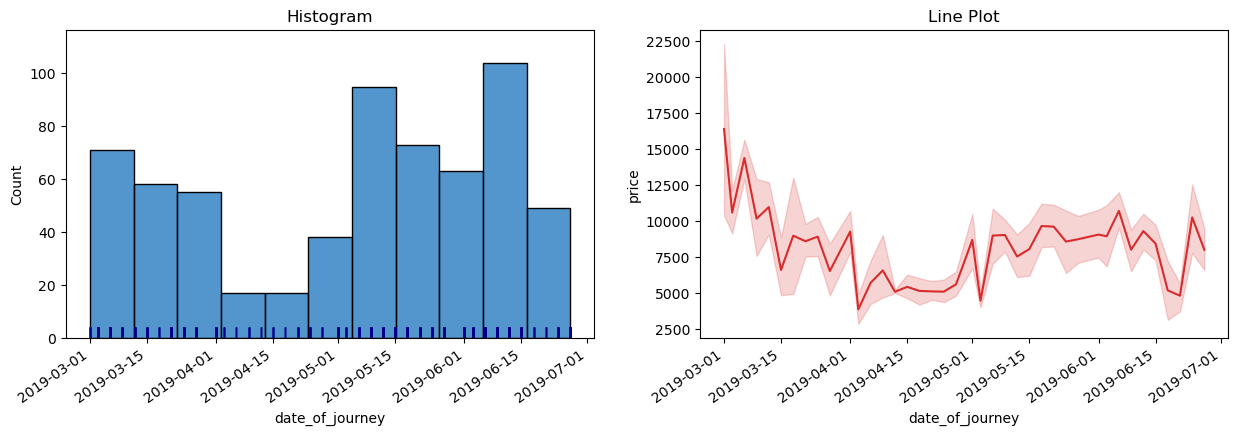

In [24]:
eda_helper_functions.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target="price"
)

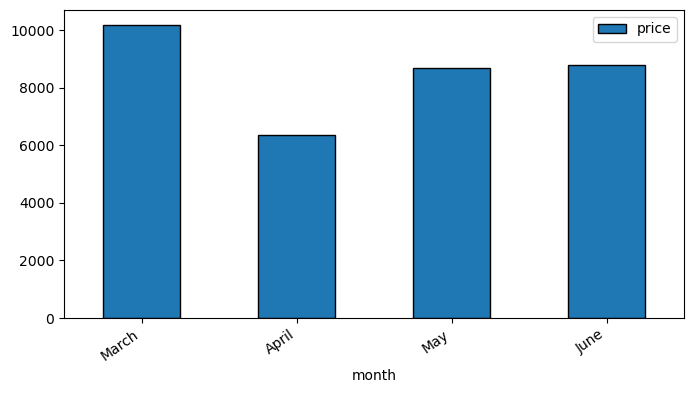

In [25]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="M"))
    .price.mean()
    .to_frame()
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="month")
    .plot(
        kind="bar",
        figsize=(8, 4),
        edgecolor="black"
    )
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

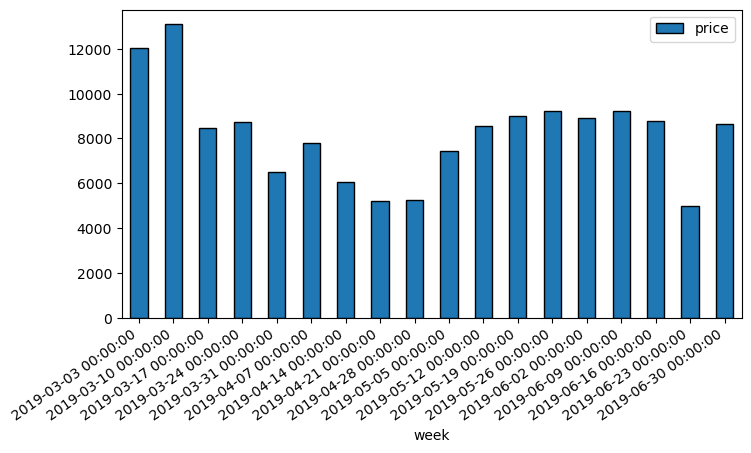

In [26]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="W"))
    .price.mean()
    .to_frame()
    .rename_axis(index="week")
    .plot(
        kind="bar",
        figsize=(8, 4),
        edgecolor="black"
    )
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

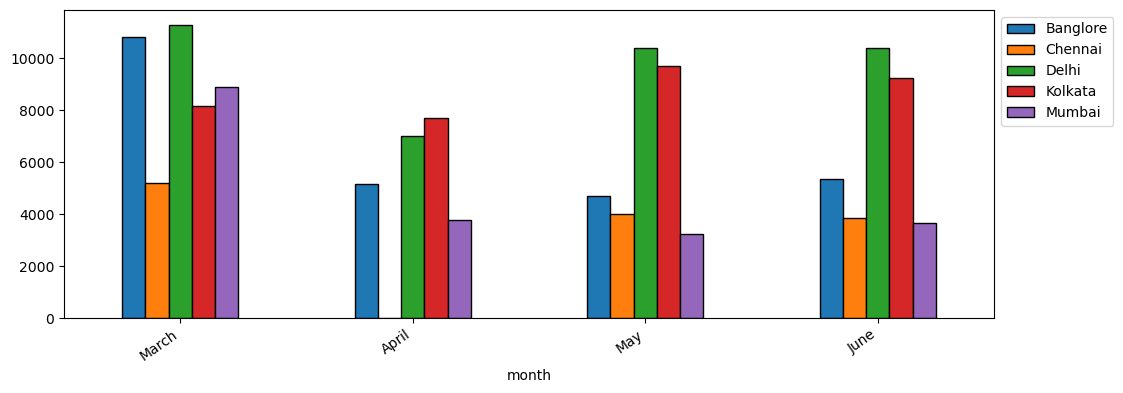

In [27]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="month")
    .plot(
        kind="bar",
        figsize=(12, 4),
        edgecolor="black"
    )
)

ax = plt.gca()

ax.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 `dep_time`

In [28]:
train.dep_time

0     2024-05-25 17:15:00
1     2024-05-25 07:10:00
2     2024-05-25 18:55:00
3     2024-05-25 09:50:00
4     2024-05-25 05:55:00
              ...        
635   2024-05-25 19:15:00
636   2024-05-25 02:55:00
637   2024-05-25 09:45:00
638   2024-05-25 22:10:00
639   2024-05-25 08:35:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

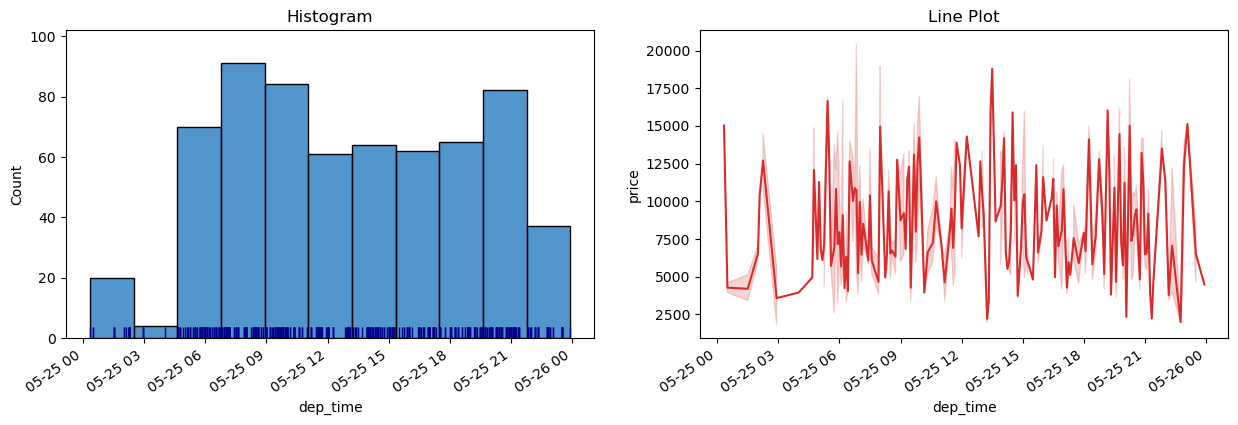

In [29]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

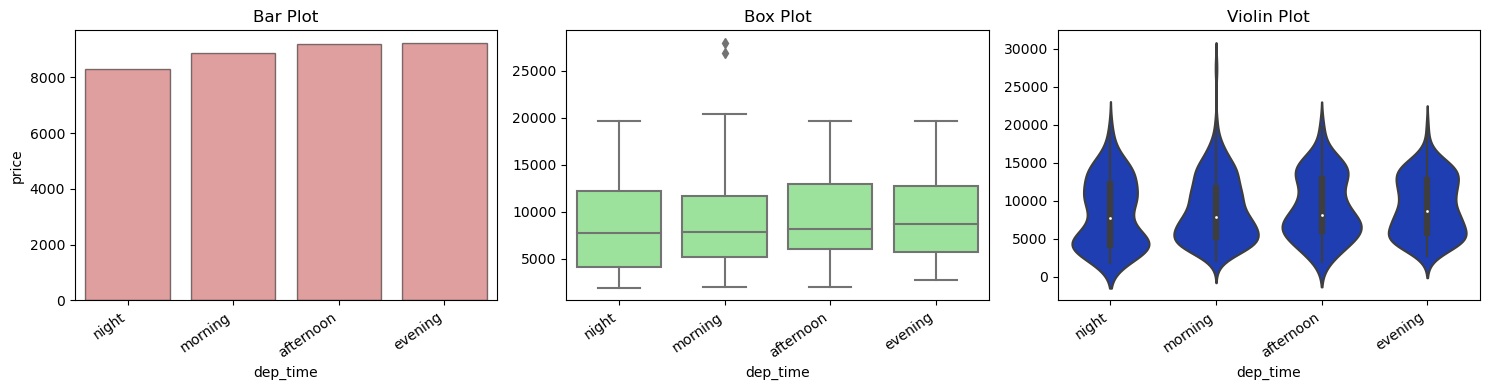

In [30]:
(
    train
    .assign(dep_time=lambda df_: (
        np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
                   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
                   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
                  ["morning", "afternoon", "evening"],
                  default="night")
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 8.4 `duration`

In [31]:
train.duration

0      1560
1      1655
2       185
3       805
4       160
       ... 
635     550
636      90
637     385
638     170
639     835
Name: duration, Length: 640, dtype: int64

In [32]:
eda_helper_functions.num_summary(train, "duration")

0      1560
1      1655
2       185
3       805
4       160
       ... 
635     550
636      90
637     385
638     170
639     835
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,80.00
5,90.00
10,145.00
25,170.00
50,480.00
75,976.25
90,1461.00
95,1615.25
99,1802.45


,value
mean,636.398438
trimmed mean (5%),604.791667
trimmed mean (10%),576.796875
median,480.000000


,value
var,264169.833174
std,513.974545
IQR,806.250000
mad,315.000000
coef_variance,0.807630


,value
skewness,0.80791
kurtosis,-0.50905


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 3.934455503040066e-22
Test Statistic       : 0.8763648867607117
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 27.990859872652777
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [33]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    170.00
0.50    480.00
0.75    976.25
Name: duration, dtype: float64

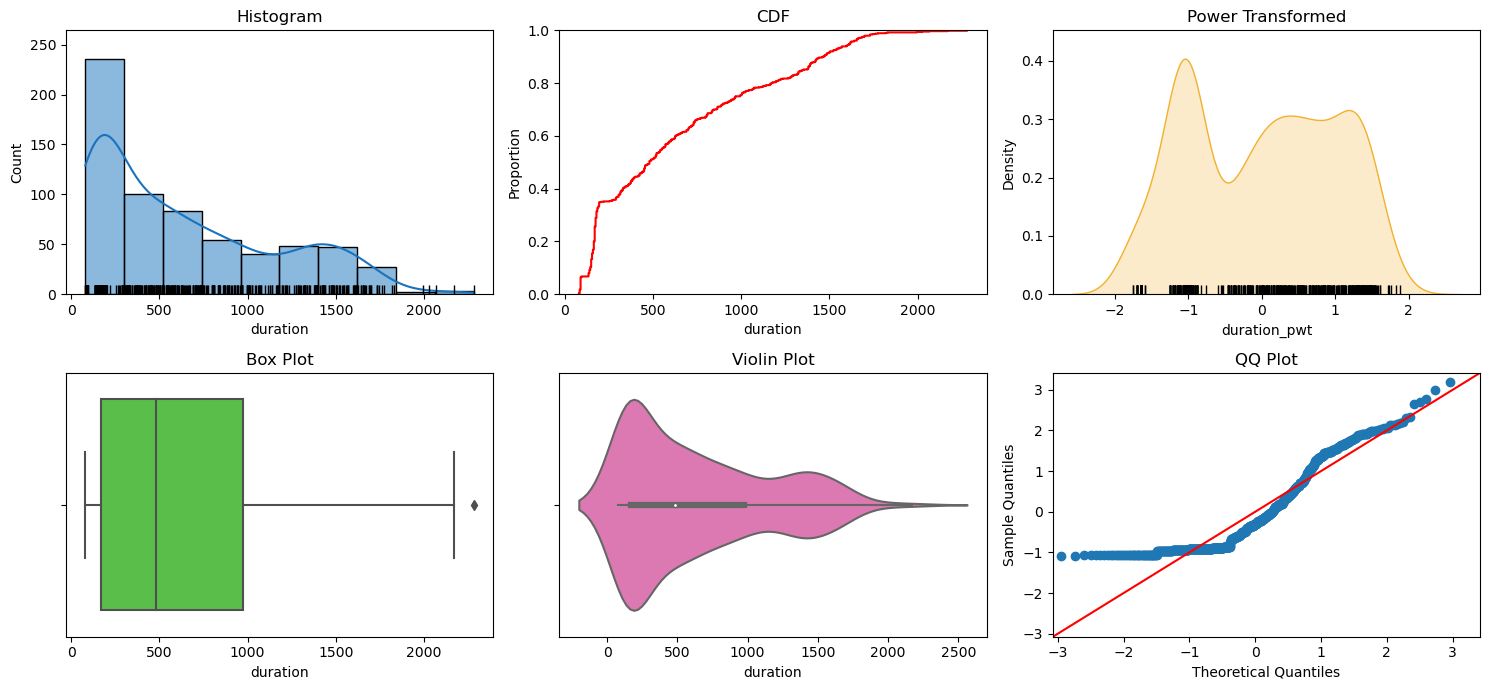

In [34]:
eda_helper_functions.num_univar_plots(train, "duration")

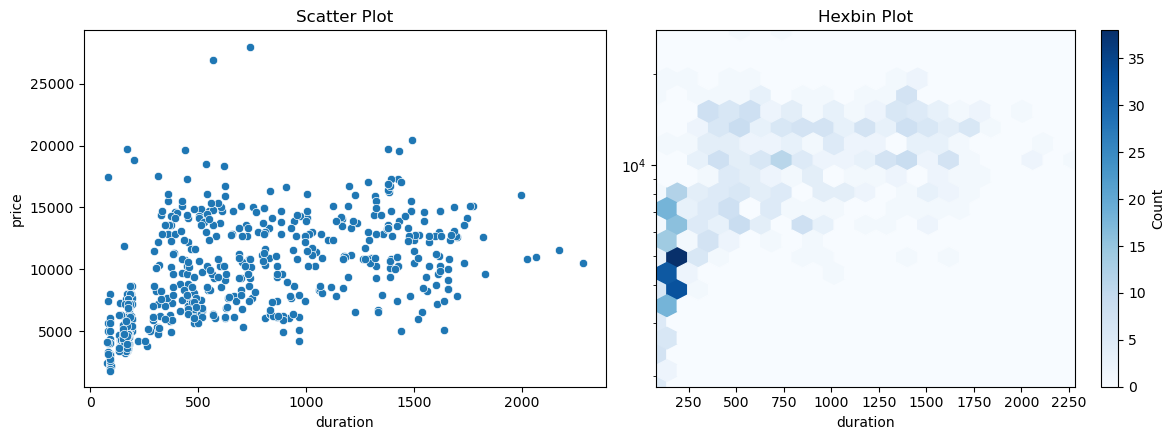

In [35]:
eda_helper_functions.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs=dict(
        yscale="log",
        gridsize=20,
        cmap="Blues"
    )
)

In [36]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5817672588892444
- p-value              : 3.1054780266347814e-59
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.7211894379804008
- p-value              : 8.388312181409264e-104
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


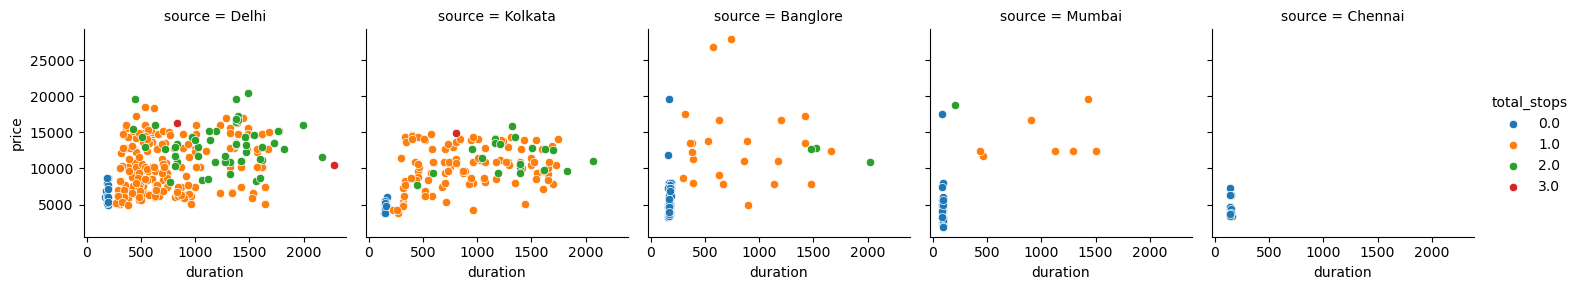

In [37]:
duration_grid = sns.FacetGrid(
    data=train,
    col="source",
    hue="total_stops",
    sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

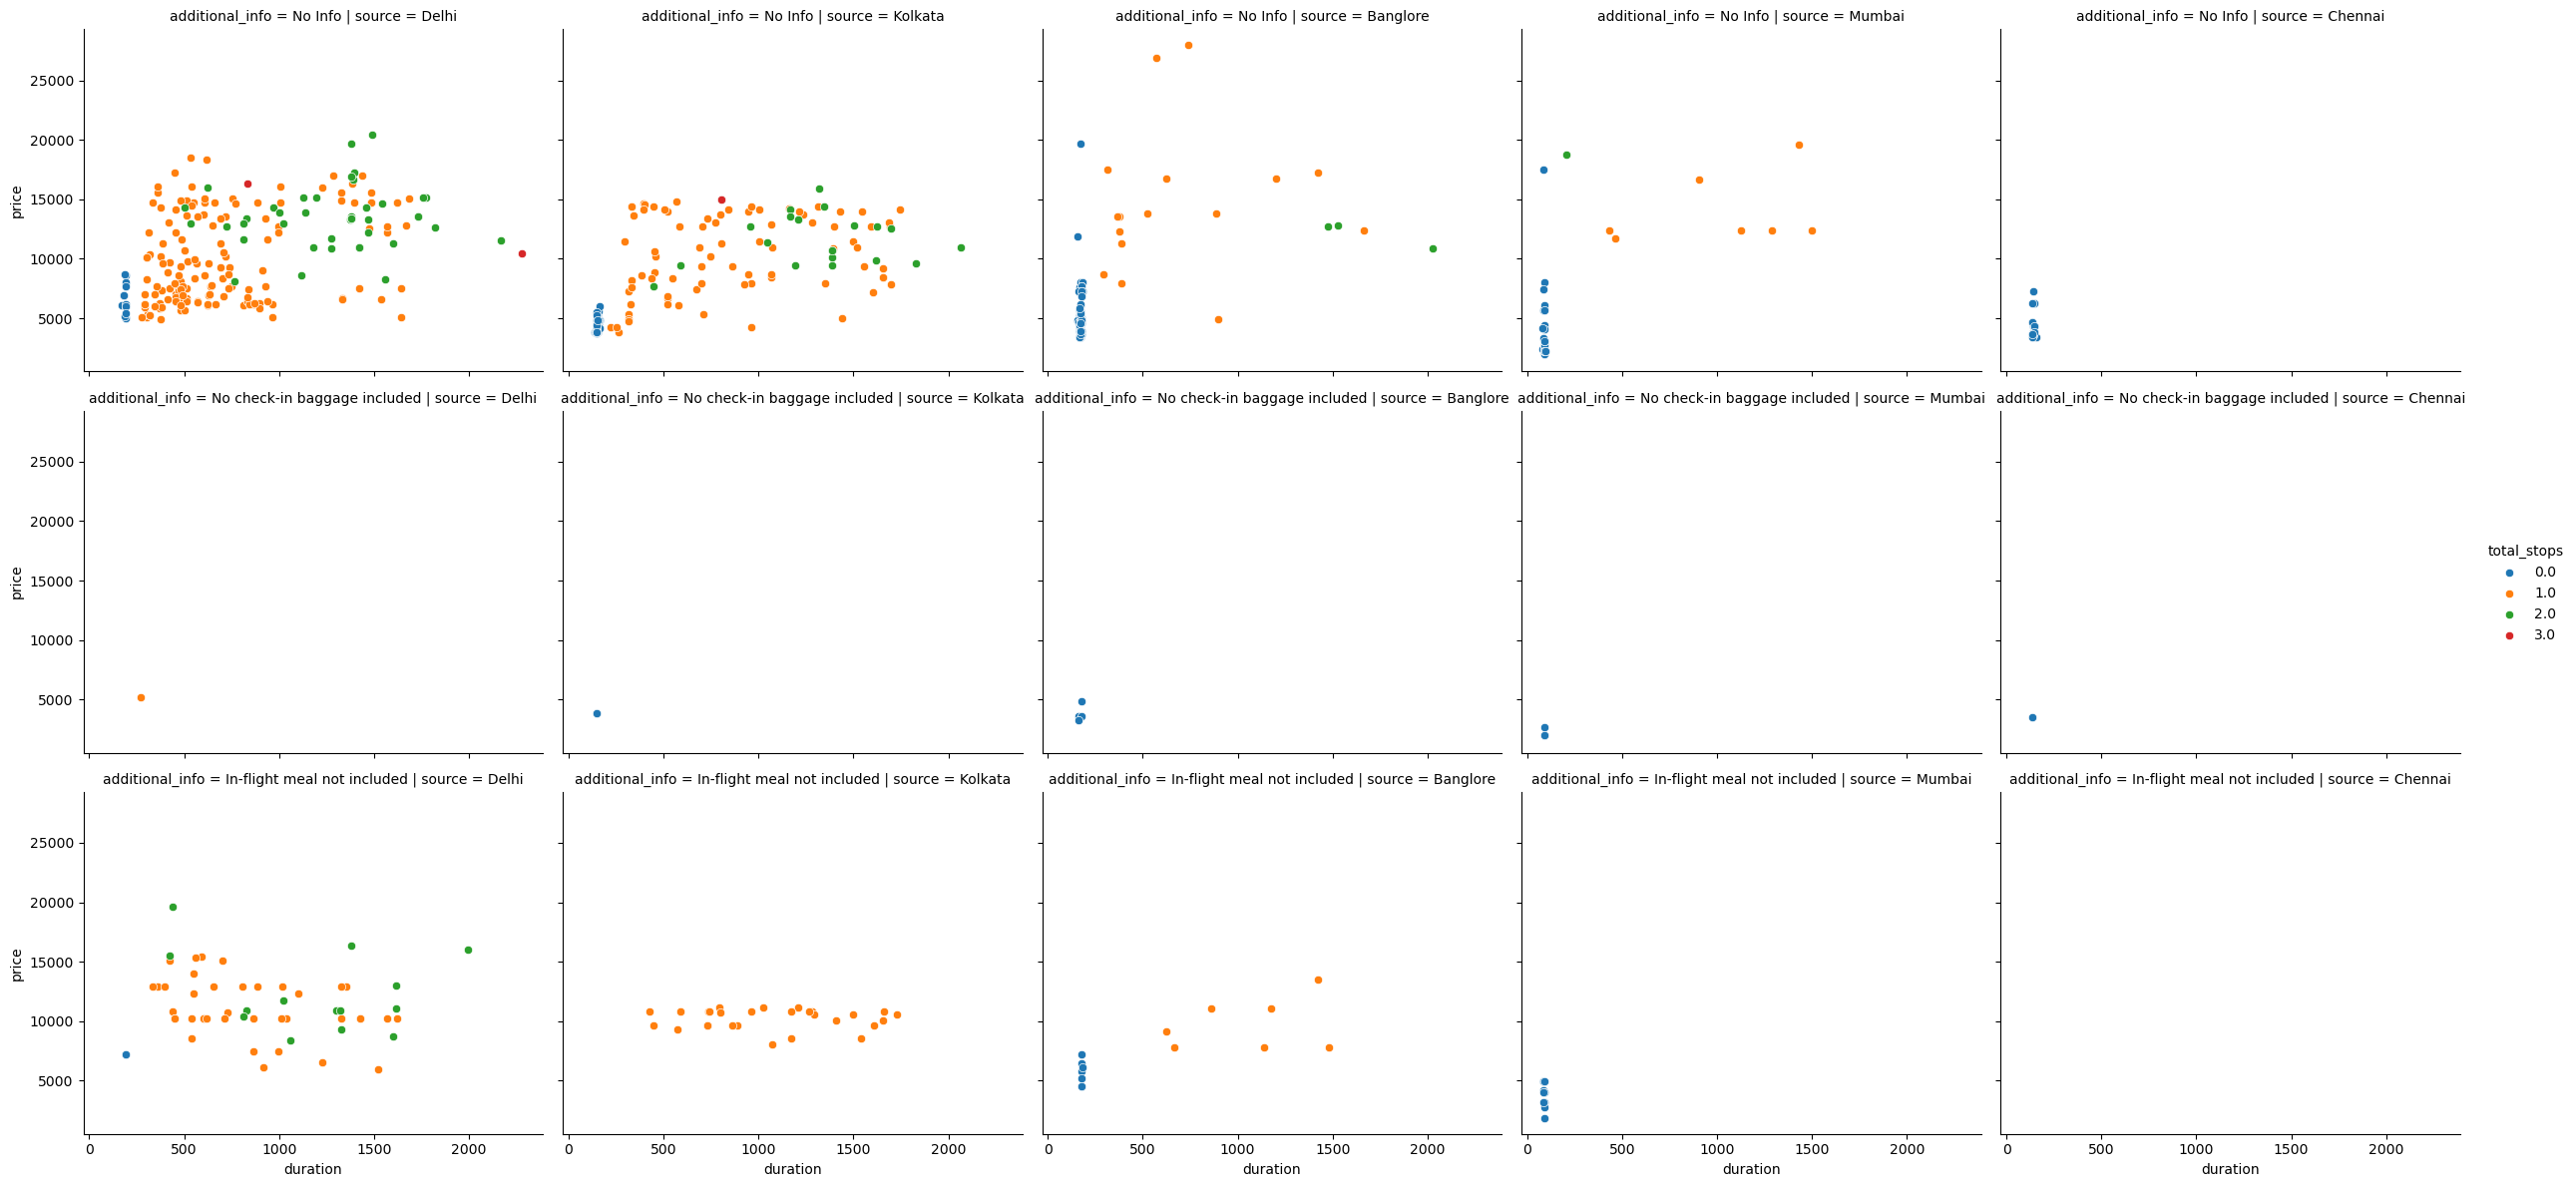

In [38]:
duration_grid = sns.FacetGrid(
    data=train,
    col="source",
    row="additional_info",
    hue="total_stops",
    sharey=True,
    height=4,  # Height of each subplot in inches
    aspect=1.25  # Width-to-height ratio of each subplot
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [39]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -1039.375
Upper Limit : 2185.625


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
178,Air India,2019-06-03,Delhi,Cochin,2024-05-25 05:15:00,2024-05-25 19:15:00,2280,3.0,No Info,10493


### 8.5 `additional_info`

In [40]:
eda_helper_functions.cat_summary(train, "additional_info")

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4      No check-in baggage included
                   ...             
635     In-flight meal not included
636     In-flight meal not included
637                         No Info
638                         No Info
639                         No Info
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 3 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,3
top,No Info
freq,517


,count,percentage
category,,
No Info,517,0.807813
In-flight meal not included,110,0.171875
No check-in baggage included,13,0.020313


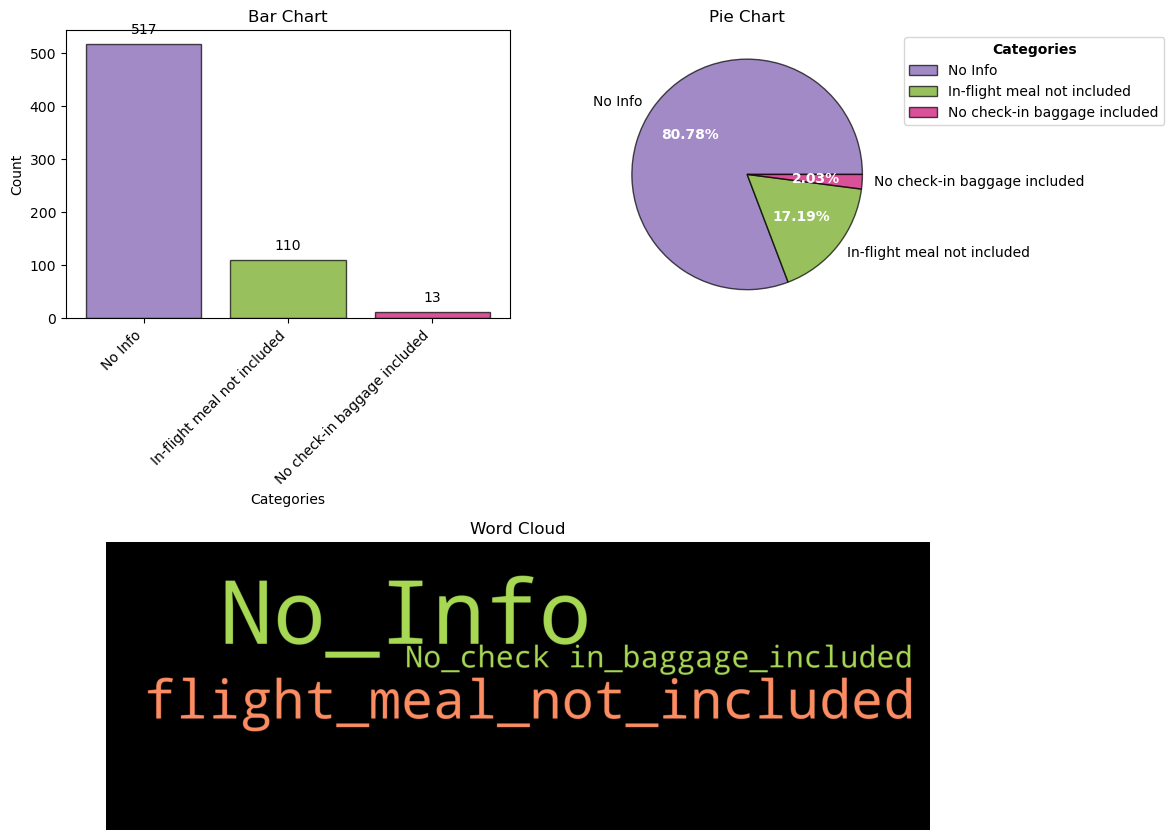

In [41]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

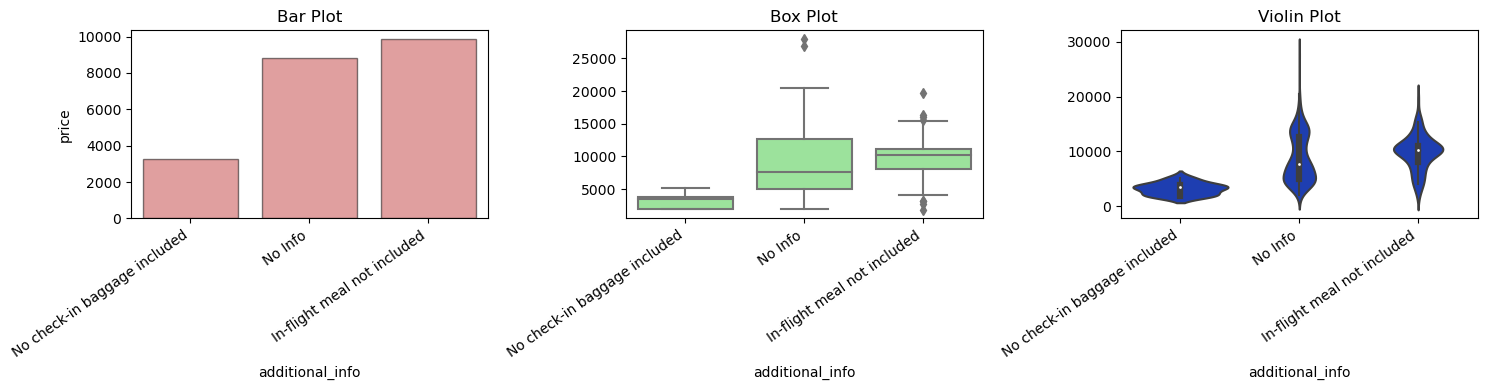

In [42]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

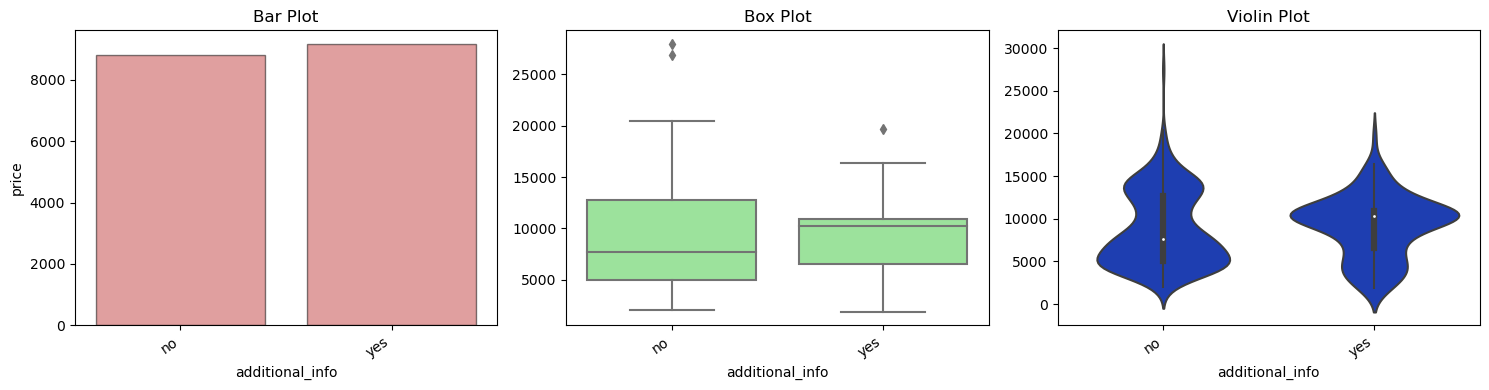

In [43]:
# convertion additional_info into a binary feature for analysis

(
    train
    .assign(additional_info=(
        train
        .additional_info
        .pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

**Observations**:

- The feature `additional_info` has severely rare categories, therefore conervting it into a binary feature for further analysis.

## 9. Automated EDA

In [44]:
from ydata_profiling import ProfileReport
report = ProfileReport(train)

report.to_file(output_file="eda-output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]